In [28]:
import pandas as pd
df_train = pd.read_csv('./source/datasets/df_treino.csv')
df_test = pd.read_csv('./source/datasets/df_teste.csv')


In [29]:
print(df_train['Resultado'].value_counts())
print(df_test['Resultado'].value_counts())

0    5626
1     158
Name: Resultado, dtype: int64
0    1409
1      32
Name: Resultado, dtype: int64


In [96]:
y_test = df_test['Resultado'].to_numpy()
X_test = df_test.drop(['Resultado'], axis=1).to_numpy()

In [30]:
y_train = df_train['Resultado'].to_numpy()
X_train = df_train.drop(['Resultado'], axis=1).to_numpy()

In [31]:
y_train_save = y_train
X_train_save = X_train

## 1) Balanceando as classes

Primeiramente, precisamos garantir representatividade de ao menos 1,5x da classe majoritária sobre a minoritária. Como temos consideravelmente mais instâncias de pessoas que não faleceram, vamos buscar utilizar diferentes técnicas tanto para selecionar instâncias da classe majoritária quanto para aumentar as instâncias da classe majoritária

Para isso, iremos utilizar a biblioteca imblearn

In [32]:
# !pip install imblearn

Primeiramente, aumentar a instância da classe minoritaria até atingir 20% da majoritária

In [33]:
from imblearn.over_sampling import SMOTE
import numpy as np

oversample = SMOTE(sampling_strategy=0.2, random_state=42)
print("Quantidade da classe minoritária antes da aumentação: ", np.unique(y_train, return_counts=True))

X_train, y_train = oversample.fit_resample(X_train, y_train)
print("Quantidade da classe minoritária após aumentação: ", np.unique(y_train, return_counts=True))

Quantidade da classe minoritária antes da aumentação:  (array([0, 1]), array([5626,  158]))
Quantidade da classe minoritária após aumentação:  (array([0, 1]), array([5626, 1125]))


Agora, vamos utilizar undersampling para reduzir a classe majoritária. 

In [34]:
from imblearn.under_sampling import NearMiss

nm = NearMiss(sampling_strategy={0:1687,1:1125})
X_train, y_train = nm.fit_resample(X_train, y_train)
print(X_train.shape)
print(y_train.shape)

(2812, 20)
(2812,)


In [35]:
import numpy as np
print(np.unique(y_train, return_counts=True))

(array([0, 1]), array([1687, 1125]))


## 2) Treinamento do modelo

A análise anterior foi usada apenas para demonstrar como devem ser balanceados os modelos. O balanceamento será realizado dentro dos folds de treinamento para cada iteração do k-fold, a fim de que a valicação reflita melhor os padrões que serão vistos nos conjuntos de teste

In [36]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.metrics import classification_report

X_train = X_train_save
y_train = y_train_save

print(np.unique(y_train, return_counts=True))

(array([0, 1]), array([5626,  158]))


In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

param_grids = {
    'kNN': {
        'n_neighbors': [1, 5, 10],
        'p': [1, 2],
        'weights': ['uniform', 'distance']
    },
    'Logistic Regression': {
        'class_weight': ['balanced', {0: 1, 1: 1}]
    },
    'Random Forest': {
        'n_estimators': [10, 100, 200],
        'max_depth': [10, 50],
        'min_samples_split': [2, 10, 30]
    }
}


Agora que já temos os parâmetros iniciais, instanciando os modelos:

In [44]:
# Modelos base
knn = KNeighborsClassifier()
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)

models = [('kNN', knn), ('Logistic Regression', lr), ('Random Forest', rf)]

In [109]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, f1_score, precision_score


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

save_best_models = {'kNN':[], 'Logistic Regression':[], 'Random Forest':[]}
predictions_per_model = {'kNN':[], 'Logistic Regression':[], 'Random Forest':[]}

all_reports = {}
for name, base_model in models:

    print(f"MODELO: {name}")
    all_reports[name] = []
    predictions_per_model[name] = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        print(f'Fold {fold+1}')
        X_train_fold, X_val = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val = y_train[train_idx], y_train[val_idx]

        # Transformando classe minoritária em 20% da classe majoritária
        oversample = SMOTE(sampling_strategy=0.2, random_state=42)
        X_train_fold, y_train_fold = oversample.fit_resample(X_train_fold, y_train_fold)

        # Transformando classe majoritária em 1.5x da minoritária
        nm = NearMiss(sampling_strategy=0.6)
        X_train_fold, y_train_fold = nm.fit_resample(X_train_fold, y_train_fold)

        # Mostrando a distribuição do y treino, para ver se o 60% foi respeitado
        print("Distribuição y treino: ", np.unique(y_train_fold, return_counts=True))

        # Clonando o modelo
        model = clone(base_model)

        # Definindo o GridSearch
        grid = GridSearchCV(
            model,
            param_grid=param_grids[name],
            scoring={'recall': 'recall', 'precision': 'precision'},
            refit='recall',  # Mais importante para prever o nosso modelo
            cv=5,
            n_jobs=1)

        # Ajustando o modelo com os dados balanceados
        grid.fit(X_train_fold, y_train_fold)

        # Usando o melhor modelo
        best_model = grid.best_estimator_

        # Avaliando o modelo
        y_pred = best_model.predict(X_val)

        # Calculando as métricas
        accuracy = accuracy_score(y_val, y_pred)
        balanced_acc = balanced_accuracy_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred, zero_division=0)
        f1 = f1_score(y_val, y_pred, zero_division=0)
        precision = precision_score(y_val, y_pred, zero_division=0)

        # Salvando como lista [acc, balanced_acc, recall, f1]
        metrics = {'model_iteration': f'{name}_{fold}','precision': precision,'accuracy': accuracy, 'balanced_accuracy': balanced_acc, 'recall': recall, 'f1_score': f1}
        all_reports[name].append(metrics)

        save_best_models[name].append(best_model)
        predictions_per_model[name].append({'predicted': y_pred, 'actual': y_val})
    

MODELO: kNN
Fold 1
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
Fold 2
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
Fold 3
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
Fold 4
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
Fold 5
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
MODELO: Logistic Regression
Fold 1
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
Fold 2
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
Fold 3
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
Fold 4
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
Fold 5
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
MODELO: Random Forest
Fold 1
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
Fold 2
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
Fold 3
Distribuição y treino:  (array([0, 1]), array([1500,  900]))
Fold 4
Distribuição y treino:  (array([0, 1]), array([

Para cada modelo treinado, avaliaremos os folds, escolhendo um melhor. O critério principal será o f1 score, e como desempate o recall, e posteriormente a acurácia balanceada.

In [110]:
metrics_knn = pd.DataFrame(all_reports['kNN'], columns=['model_iteration','precision','accuracy', 'balanced_accuracy', 'recall', 'f1_score'])
metrics_logreg = pd.DataFrame(all_reports['Logistic Regression'], columns=['model_iteration', 'precision', 'accuracy', 'balanced_accuracy', 'recall', 'f1_score'])
metrics_rf = pd.DataFrame(all_reports['Random Forest'], columns=['model_iteration', 'precision', 'accuracy', 'balanced_accuracy', 'recall', 'f1_score'])

metrics = pd.concat([metrics_knn, metrics_logreg, metrics_rf], axis=0)
metrics

,model_iteration,precision,accuracy,balanced_accuracy,recall,f1_score
0,kNN_0,0.182796,0.922213,0.740446,0.548387,0.274194
1,kNN_1,0.180952,0.914434,0.758653,0.593750,0.277372
2,kNN_2,0.180556,0.892826,0.853806,0.812500,0.295455
3,kNN_3,0.208333,0.923941,0.778722,0.625000,0.312500
4,kNN_4,0.193798,0.904844,0.857004,0.806452,0.312500
0,Logistic Regression_0,0.222222,0.938634,0.733198,0.516129,0.310680
1,Logistic Regression_1,0.183099,0.933449,0.677347,0.406250,0.252427
2,Logistic Regression_2,0.255814,0.936041,0.815306,0.687500,0.372881
3,Logistic Regression_3,0.273973,0.943820,0.788944,0.625000,0.380952
4,Logistic Regression_4,0.282353,0.941176,0.859986,0.774194,0.413793


Escolhendo o melhor fold para cada algoritmo, considerando o recall como métrica principal

In [111]:
# O que obteve o melhor resultado foi o Knn_4
metrics_knn

,model_iteration,precision,accuracy,balanced_accuracy,recall,f1_score
0,kNN_0,0.182796,0.922213,0.740446,0.548387,0.274194
1,kNN_1,0.180952,0.914434,0.758653,0.593750,0.277372
2,kNN_2,0.180556,0.892826,0.853806,0.812500,0.295455
3,kNN_3,0.208333,0.923941,0.778722,0.625000,0.312500
4,kNN_4,0.193798,0.904844,0.857004,0.806452,0.312500


In [112]:
# O que obteve o melhor resultado foi o log_4
metrics_logreg

,model_iteration,precision,accuracy,balanced_accuracy,recall,f1_score
0,Logistic Regression_0,0.222222,0.938634,0.733198,0.516129,0.310680
1,Logistic Regression_1,0.183099,0.933449,0.677347,0.406250,0.252427
2,Logistic Regression_2,0.255814,0.936041,0.815306,0.687500,0.372881
3,Logistic Regression_3,0.273973,0.943820,0.788944,0.625000,0.380952
4,Logistic Regression_4,0.282353,0.941176,0.859986,0.774194,0.413793


In [113]:
# O que obteve o melhor resultado foi o rf_3
metrics_rf

,model_iteration,precision,accuracy,balanced_accuracy,recall,f1_score
0,Random Forest_0,0.268293,0.956785,0.664098,0.354839,0.305556
1,Random Forest_1,0.181818,0.954192,0.581750,0.187500,0.184615
2,Random Forest_2,0.311475,0.952463,0.778208,0.593750,0.408602
3,Random Forest_3,0.457143,0.969749,0.741556,0.500000,0.477612
4,Random Forest_4,0.325581,0.960208,0.712918,0.451613,0.378378


Agora, selecionaremos o melhor de cada um dos algoritmos, para efeito de comparação:

In [115]:
best_metrics = metrics.loc[
    (metrics['model_iteration'] == 'kNN_4') | 
    (metrics['model_iteration'] == 'Logistic Regression_4') |
    (metrics['model_iteration'] == 'Random Forest_3')
]
best_metrics


,model_iteration,precision,accuracy,balanced_accuracy,recall,f1_score
4,kNN_4,0.193798,0.904844,0.857004,0.806452,0.312500
4,Logistic Regression_4,0.282353,0.941176,0.859986,0.774194,0.413793
3,Random Forest_3,0.457143,0.969749,0.741556,0.500000,0.477612


Apesar de ter o melhor f1_score, em virtude do recall baixo em comparação os outros modelos, o random forest foi desconsiderado, já que o recall é uma métrica mais importante para o objetivo da predição.
Como a regressão logística foi consideravelmente superior na precisão, apesar de um recall um pouco mais baixo, consideramos que seria o melhor modelo para ser aplicado.

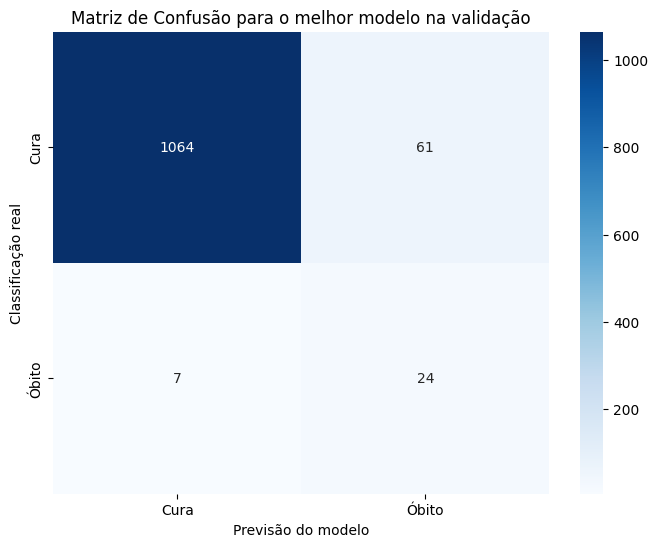

In [116]:
# Mostrando a matriz de confusão para o melhor modelo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = predictions_per_model['Logistic Regression'][4]['actual']
y_pred = predictions_per_model['Logistic Regression'][4]['predicted']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cura', 'Óbito'], yticklabels=['Cura', 'Óbito'])
plt.xlabel('Previsão do modelo')
plt.ylabel('Classificação real')
plt.title('Matriz de Confusão para o melhor modelo na validação')
plt.savefig('./source/images/matriz_confusao_validacao.png')


## Testando o melhor modelo

In [117]:
melhor_modelo = save_best_models['Logistic Regression'][4]
y_pred = melhor_modelo.predict(X_test)


Calculando as métricas para o melhor modelo no conjunto de testes:

In [118]:
results = pd.DataFrame({'precision': [precision_score(y_test, y_pred)],
              'recall': [recall_score(y_test, y_pred)],
              'f1_score': [f1_score(y_test, y_pred)]})

results



,precision,recall,f1_score
0,0.235955,0.65625,0.347107


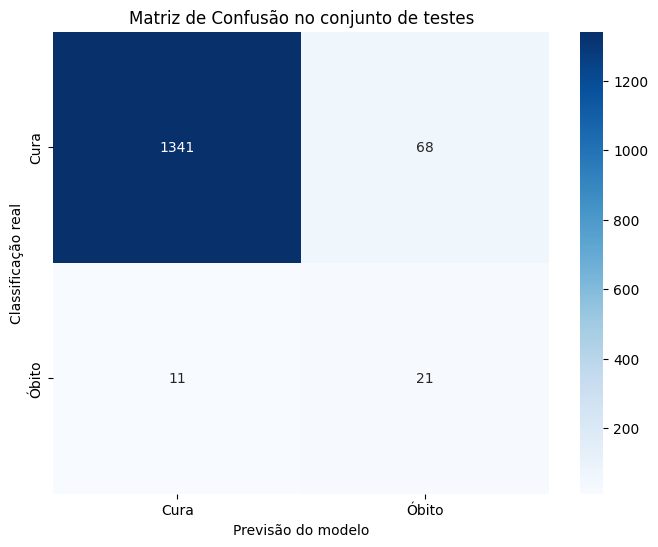

In [119]:

# Mostrando a matriz de confusão para o melhor modelo
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cura', 'Óbito'], yticklabels=['Cura', 'Óbito'])
plt.xlabel('Previsão do modelo')
plt.ylabel('Classificação real')
plt.title('Matriz de Confusão no conjunto de testes')
plt.savefig('./source/images/matriz_confusao_teste.png')